In [7]:
import Pkg
Pkg.activate(".")

dependencies = [
    "IJulia",
    "Revise",
    "Turing",
    "Bijectors",
    "ParetoSmooth",  
    "LogExpFunctions",    
    "StatsPlots",             
    "DataFrames",       
    "JLD2",            
    "CSV"
]

# Pkg.add(dependencies)
Pkg.status()

using Revise, Turing, Bijectors, ParetoSmooth, LogExpFunctions, StatsPlots, DataFrames, JLD2, CSV
using Random, LinearAlgebra

jlfiles = [
    "code/DataPreparation.jl",
    "code/Utils.jl",
    "code/MyModels.jl",
    "code/models/glm.jl",
    "code/models/glmhmm.jl",
    "code/models/iohmm.jl",
]
for file in jlfiles
    include(file)
end

# Check number of threads
println("Running on ", Threads.nthreads(), " threads.")
# Set random seed
const SEED = 123;

  Activating project at `c:\Users\michi\WorkSpace\gitwork\mich2000jp\IPD_IOHMM`


Status `C:\Users\michi\WorkSpace\gitwork\mich2000jp\IPD_IOHMM\Project.toml`
  [76274a88] Bijectors v0.15.14
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.8.1
  [7073ff75] IJulia v1.33.0
  [033835bb] JLD2 v0.6.3
  [2ab3a3ac] LogExpFunctions v0.3.29
  [a68b5a21] ParetoSmooth v0.7.16
  [295af30f] Revise v3.13.0
  [f3b207a7] StatsPlots v0.15.8
⌃ [fce5fe82] Turing v0.40.5
Info Packages marked with ⌃ have new versions available and may be upgradable.
Running on 12 threads.


In [3]:
## Data Preparation ----------------------------------------------------
CSV_FIX_PATH = "data/fix.csv"
CSV_RAND_PATH = "data/rand.csv"
DATA_FIX_PATH = "data/fix.jld2"
DATA_RAND_PATH = "data/rand.jld2"

ID_EXCLUDED_FP = []
ID_EXCLUDED_SP = []

prepare_data(CSV_FIX_PATH, DATA_FIX_PATH)
prepare_data(CSV_RAND_PATH, DATA_RAND_PATH)


data_fp = load_data(DATA_FIX_PATH, ID_excluded=ID_EXCLUDED_FP);
data_sp = load_data(DATA_RAND_PATH, ID_excluded=ID_EXCLUDED_SP);
data_fp.n_subjects

Reading CSV files...
Saving processed data to data/fix.jld2 ...
Data saved successfully.
Reading CSV files...
Saving processed data to data/rand.jld2 ...
Data saved successfully.
Data loaded successfully. Excluded IDs: Any[]
Data loaded successfully. Excluded IDs: Any[]


92

In [8]:
## MCMC Settings ----------------------------------------------------
n_iter   = 2000    # Number of samples
n_burnin = 2000    # Burn-in
n_chains = 4       # Number of chains

trt        = "sp"
model_name = "iohmm_mealy"
K_states   = 2
prefix     = "TDist3_Sig3"

sampler = NUTS(0.8; adtype=AutoForwardDiff())

println("=== Analysis Settings ===")
println("MCMC: $n_iter samples, $n_burnin burn-in, $n_chains chains")
println("Model: $model_name, K=$K_states, Condition=$trt, Prefix=$prefix")

=== Analysis Settings ===
MCMC: 2000 samples, 2000 burn-in, 4 chains
Model: iohmm_mealy, K=2, Condition=sp, Prefix=TDist3_Sig3


In [9]:
## MCMC Run ----------------------------------------------------
title = "$(trt)_$(model_name)_K$(K_states)_$prefix"
CHAIN_PATH    = "chain/$title.jld2"
SUMMARY_PATH = "output/$(title)_summary.csv"
LOO_PATH     = "output/$(title)_loo.csv"
PLOT_PATH     = "output/$(title)_plot.png"
PLOT_GQ_PATH  = "output/$(title)_plot_gq.png"

data = trt == "fp" ? data_fp : data_sp
model, model_gq = model_selector(model_name, data, K_states)
chain = RunMCMC(SEED, model, K_states, sampler, n_iter, n_chains, n_burnin, CHAIN_PATH)

=== MCMC Sampling ===


┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
┌ Info: Found initial step size
└   ϵ = 0.05
Sampling (4 threads): 100%|█████████████████████████████| Time: 2:38:24


=== MCMC Completed! ===

Saving results to 'chain/sp_iohmm_mealy_K2_TDist3_Sig3.jld2'...

Results saved successfully.


Chains MCMC chain (2000×32×4 Array{Float64, 3}):

Iterations        = 2001:1:4000
Number of chains  = 4
Samples per chain = 2000
Wall duration     = 9598.84 seconds
Compute duration  = 35448.37 seconds
parameters        = beta0[1], beta0[2], beta1[1], beta1[2], beta2[1], beta2[2], beta3[1], beta3[2], gamma0[1, 1], gamma0[1, 2], gamma1[1, 1], gamma1[1, 2], gamma2[1, 1], gamma2[1, 2], gamma3[1, 1], gamma3[1, 2], init[1], init[2]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [10]:
OUTPUT_PATH = [SUMMARY_PATH, LOO_PATH, PLOT_PATH, PLOT_GQ_PATH]
RunPostAnalysis(model_gq, chain, K_states, OUTPUT_PATH)

relabeling states...
generating quantities...
summarizing results...


Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec,lower,upper
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Float64?,Float64?
1,beta0[1],7.08328,2.02787,0.0511334,2850.17,1666.88,1.00062,missing,4.15815,11.1699
2,beta0[2],-14.1492,7.58082,0.224385,2820.19,1752.32,1.00234,missing,-27.2636,-6.43823
3,beta1[1],-6.63093,2.02938,0.0511546,2854.75,1653.34,1.00052,missing,-10.7083,-3.71649
4,beta1[2],-0.743833,4.10636,0.0645743,6891.32,2929.27,1.00067,missing,-8.93128,7.01419
5,beta2[1],1.33933,1.99811,0.0336712,4160.11,3000.98,1.00076,missing,-2.53249,5.25541
6,beta2[2],-1.24665,4.04933,0.067238,7561.47,3268.94,1.00082,missing,-9.33513,6.01245
7,beta3[1],-0.263385,1.99846,0.033662,4175.19,3016.31,1.00073,missing,-4.37196,3.43144
8,beta3[2],-0.375835,6.83921,0.297581,2514.08,1678.46,1.00194,missing,-10.3967,9.33017
9,"gamma0[1, 1]",-0.200075,0.0587189,0.000670237,7691.78,5984.06,1.00005,missing,-0.312469,-0.0841523


Plotting MCMC Results...
PSIS-LOO Calculation...
There are 62 subjects with pareto k > 0.7, and 23 subjects with 0.5 < pareto k ≤ 0.7.
Subject 1: pareto k = 0.8596984334765018
Subject 2: pareto k = 0.5391560687262161
Subject 3: pareto k = 0.897332344221478
Subject 4: pareto k = 0.9452849010659982
Subject 5: pareto k = 1.222271130870767
Subject 7: pareto k = 1.1009796027145646
Subject 8: pareto k = 1.275561635217773
Subject 9: pareto k = 0.976254022974428
Subject 10: pareto k = 0.6083883939411869
Subject 11: pareto k = 1.3098437978382778
Subject 12: pareto k = 1.1071389730575352
Subject 13: pareto k = 0.5674841329480456
Subject 14: pareto k = 1.7949861339079827
Subject 15: pareto k = 0.7821378627700024
Subject 16: pareto k = 0.584254307225483
Subject 17: pareto k = 1.275397504936433
Subject 19: pareto k = 1.6443818903789647
Subject 20: pareto k = 0.5353693118099688
Subject 21: pareto k = 0.729979955981546
Subject 22: pareto k = 1.2834911895783865
Subject 23: pareto k = 0.811241513148515

[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


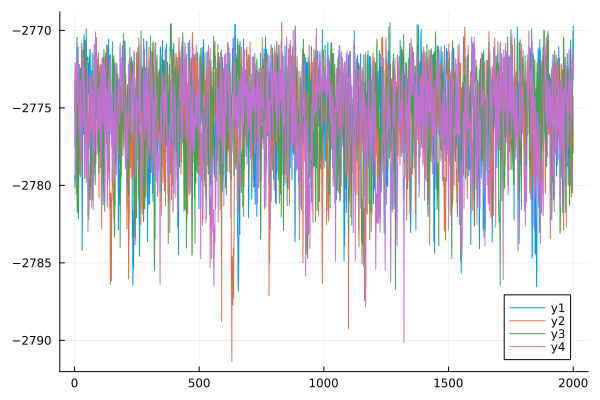

In [ ]:
plot(chain[:lp])


plot(chain_A[:lp])

# chain_B=chain[:, :, chn_B]
# plot(chain_B[:lp])

In [15]:
# chn_A = [3,4,10,12]
chn_A = [1,2,3,4]
chain_A = chain[:, :, chn_A]
CHAIN_PATH_A = "chain/$(title)_A.jld2"
OUTPUT_PATH_A = [
    "output/$(title)_A_summary.csv",
    "output/$(title)_A_loo.csv",
    "output/$(title)_A_plot.png",
    "output/$(title)_A_plot_gq.png"
]
RunPostAnalysis(model_gq, chain_A, K_states, OUTPUT_PATH_A)
@save CHAIN_PATH_A chain_A

# chn_B = [1,2,6,7]
chn_B=[11]
chain_B = chain[:, :, chn_B]
CHAIN_PATH_B = "chain/$(title)_B.jld2"
OUTPUT_PATH_B = [
    "output/$(title)_B_summary.csv",
    "output/$(title)_B_loo.csv",
    "output/$(title)_B_plot.png",
    "output/$(title)_B_plot_gq.png"
]
RunPostAnalysis(model_gq, chain_B, K_states, OUTPUT_PATH_B)
@save CHAIN_PATH_B chain_B

relabeling states...
generating quantities...
summarizing results...


Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec,lower,upper
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Float64?,Float64?
1,beta0[1],-1.64532,0.0724154,0.00137263,2800.42,3470.52,1.00065,missing,-1.78568,-1.50284
2,beta0[2],-5.8761,0.847264,0.0187682,3140.07,2584.12,1.0018,missing,-7.47602,-4.47565
3,beta1[1],1.38002,0.109107,0.00196639,3093.35,3802.38,1.00092,missing,1.16344,1.58666
4,beta1[2],17.2107,9.97876,0.361394,1210.24,1204.9,1.00141,missing,7.35821,35.0684
5,beta2[1],1.18672,0.10328,0.00190598,2969.9,2907.61,1.0008,missing,0.971758,1.38234
6,beta2[2],1.36946,1.3526,0.0256008,3359.19,2638.4,1.00038,missing,-1.40342,3.87926
7,beta3[1],0.841872,0.154421,0.00273494,3199.75,4159.41,1.00048,missing,0.527706,1.13703
8,beta3[2],2.45968,4.18312,0.0817273,3753.16,1972.14,1.00082,missing,-5.8206,10.7218
9,"trans[1, 1]",0.996842,0.00129524,2.04221e-5,3609.78,2987.9,1.00087,missing,0.994167,0.999006


Plotting MCMC Results...
PSIS-LOO Calculation...
There are 1 subjects with pareto k > 0.7, and 2 subjects with 0.5 < pareto k ≤ 0.7.
Subject 11: pareto k = 0.5714147503460897
Subject 16: pareto k = 0.7840034648331047
Subject 83: pareto k = 0.5440654672608795
All done!


[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


relabeling states...
generating quantities...
summarizing results...


Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec,lower,upper
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Float64?,Float64?
1,beta0[1],-3.09647,0.123971,0.00350359,1254.17,1229.64,1.00059,missing,-3.3335,-2.84259
2,beta0[2],-0.705573,0.111912,0.00327607,1154.35,1397.69,1.00128,missing,-0.918247,-0.486174
3,beta1[1],2.58691,0.198515,0.00521845,1446.19,1332.68,0.99976,missing,2.19347,2.95929
4,beta1[2],1.50775,0.139855,0.0045711,936.741,1626.93,1.00055,missing,1.24387,1.77002
5,beta2[1],2.55988,0.186045,0.00523339,1271.4,1281.47,1.00286,missing,2.19257,2.91798
6,beta2[2],-0.129697,0.150217,0.00457569,1065.67,1204.43,0.999952,missing,-0.42253,0.167025
7,beta3[1],4.28791,0.841132,0.0316698,1617.12,802.599,1.00468,missing,3.04327,5.76202
8,beta3[2],0.546357,0.195431,0.00619519,976.539,1416.16,1.00114,missing,0.163293,0.901544
9,"trans[1, 1]",0.994451,0.00125113,2.88636e-5,1830.58,1100.45,1.00114,missing,0.99185,0.996668


Plotting MCMC Results...
PSIS-LOO Calculation...
There are 1 subjects with pareto k > 0.7, and 3 subjects with 0.5 < pareto k ≤ 0.7.
Subject 11: pareto k = 0.5472903231833511
Subject 16: pareto k = 0.8300354146342844
Subject 20: pareto k = 0.6462039473536658
Subject 83: pareto k = 0.6487499062977856
All done!


[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


In [6]:
## Visualization of State Dynamics ----------------------------------------------------
include("models.jl")
include("mcmc_utils.jl")

chain_relabeled = relabel_chain(chain, K_states)
bigtrt = trt == "fp" ? "FP" : "SP"

if model_name == "glmhmm"
    bigmodelname = "GLM-HMM"
elseif model_name == "iohmm"
    bigmodelname = "IO-HMM (Mealy)"
elseif model_name == "moorehmm"
    bigmodelname = "IO-HMM (Moore)"
end

n_samples = n_iter * n_chains
all_states = decoder(model_name, data, chain_relabeled, K_states; n_samples)

p = plot_transition(all_states,
    title = "Transition Dynamics & State Composition ($bigtrt, $bigmodelname, $K_states states)",)
savefig(p, "output/stateplot_$title.png")

LoadError: SystemError: opening file "c:\\Users\\michi\\WorkSpace\\gitwork\\mich2000jp\\IPD_IOHMM\\models.jl": No such file or directory

[ Info: No source provided for samples; variables are assumed to be from a Markov Chain. If the samples are independent, specify this with keyword argument `source=:other`.


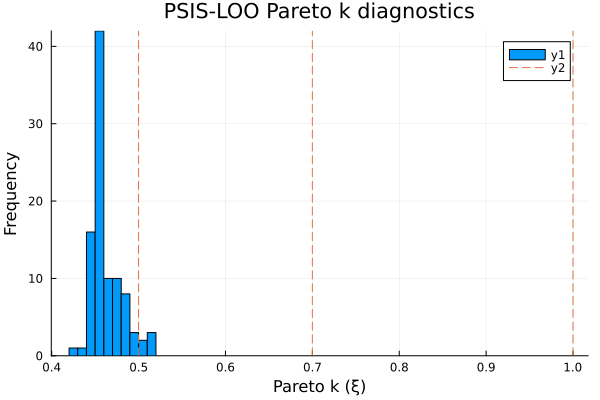

In [ ]:
## PSIS-LOO Pareto k diagnostics ----------------------------------------------------
loo = RunPSISLOO(model, chain_relabeled)
pareto_k = loo.pointwise(statistic = :pareto_k) |> collect
p = histogram(
    pareto_k;
    bins = :auto,
    xlabel = "Pareto k (ξ)",
    ylabel = "Frequency",
    title = "PSIS-LOO Pareto k diagnostics"
)
vline!(
    [0.5, 0.7, 1.0],
    linestyle = :dash,
)
savefig("output/pareto_k_$title.png")
display(p)



In [16]:
Pkg.status()

Status `C:\Users\michi\WorkSpace\gitwork\mich2000jp\hmm\Project.toml`
  [76274a88] Bijectors v0.15.14
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.8.1
  [31c24e10] Distributions v0.25.122
  [033835bb] JLD2 v0.6.3
  [2ab3a3ac] LogExpFunctions v0.3.29
⌃ [c7f686f2] MCMCChains v7.6.0
  [86f7a689] NamedArrays v0.10.5
  [a68b5a21] ParetoSmooth v0.7.16
  [91a5bcdd] Plots v1.41.3
  [10745b16] Statistics v1.11.1
  [4c63d2b9] StatsFuns v1.5.2
  [f3b207a7] StatsPlots v0.15.8
⌃ [fce5fe82] Turing v0.40.5
  [37e2e46d] LinearAlgebra v1.12.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 4
Samples per chain = 1000
parameters        = pcc[1], pcc[2], pcd[1], pcd[2], pdc[1], pdc[2], pdd[1], pdd[2], beta0[1], beta0[2]

Use `describe(chains)` for summary statistics and quantiles.
